[![Abrir en Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/estebanbecerra/MLEX-Practicas/blob/main/AirQualityRandomForest.ipynb)

**Asignatura**: MACHINE LEARNING EXPLICABLE <br>
**Curso**: 2024/2025

**Alumnos**:<br>
- Esteban Becerra Fern√°ndez (esteban.becerraf@um.es)
- Salvador de Haro Orenes (salvadorde.haroo@um.es)
- Jose Mar√≠a Belmonte Mart√≠nez (josemaria.belmontem@um.es)

**M√°ster de Inteligencia Artificial**

**Facultad de Inform√°tica**

![](https://www.um.es/image/layout_set_logo?img_id=175281&t=1726728636242)

**Universidad de Murcia**

![](https://www.um.es/o/um-lr-principal-um-home-theme/images/logo-um.png)

# Introducci√≥n

En este notebook usaremos un modelo `Random Forest` para predecir la calidad del aire. Es decir, nos encontramos en un escenario de aprendizaje supervisado para regresi√≥n.

A lo largo del notebook abordaremos las etapas principales de todo proceso de machine learning:
1. Carga y preprocesamiento de datos.
2. Divisi√≥n de los datos en entrenamiento y test.
3. Creaci√≥n y ajuste del modelo.

Y acabaremos con lo realmente interesante para esta asignatura, que es el uso de m√©todos explicativos, tales como `LIME` o `SHAP`, para poder interpretar c√≥mo el modelo Random Forest est√° llevando a cabo sus predicciones.

# Configuraci√≥n del entorno

## Clonar repositorio GitHub con el fichero de datos .csv

In [1]:
# Clonar el repositorio en Google Colab
!git clone https://github.com/estebanbecerra/MLEX-Practicas.git
%cd MLEX-Practicas

# Confirmar clonaci√≥n exitosa
print("‚úÖ Repositorio clonado con √©xito.")

fatal: destination path 'MLEX-Practicas' already exists and is not an empty directory.
/content/MLEX-Practicas
‚úÖ Repositorio clonado con √©xito.


## Importaci√≥n de librer√≠as

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
from lime.lime_tabular import LimeTabularExplainer
import shap
from sklearn.preprocessing import RobustScaler
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## Semilla para la reproducibilidad de resultados

In [3]:
random_state = 1234

# Carga de datos y preprocesamiento

## **Air Quality Dataset**

El conjunto de datos contiene 9357 instancias de respuestas promediadas por hora de una matriz de 5 sensores qu√≠micos de √≥xidos met√°licos integrados en un Dispositivo Multisensor de Calidad del Aire. El dispositivo se ubic√≥ en el campo en una zona significativamente contaminada, a nivel de la carretera, dentro de una ciudad italiana. Los datos se registraron desde marzo de 2004 hasta febrero de 2005 (un a√±o), representando las grabaciones m√°s largas disponibles de manera libre sobre las respuestas de dispositivos sensores qu√≠micos de calidad del aire desplegados en campo.

Las concentraciones promediadas por hora de referencia para mon√≥xido de carbono (CO), hidrocarburos no met√°nicos, benceno, √≥xidos de nitr√≥geno totales (NOx) y di√≥xido de nitr√≥geno (NO2) fueron proporcionadas por un analizador certificado de referencia ubicado en el mismo sitio. Los valores faltantes est√°n etiquetados con el valor -200.

In [4]:
# Cargar CSV
df = pd.read_csv("AirQuality.csv", sep=";")

# Mostrar las primeras filas
df.head()

Date      Time CO(GT)  PT08.S1(CO)  NMHC(GT) C6H6(GT)  PT08.S2(NMHC)  \
0  10/03/2004  18.00.00    2,6       1360.0     150.0     11,9         1046.0   
1  10/03/2004  19.00.00      2       1292.0     112.0      9,4          955.0   
2  10/03/2004  20.00.00    2,2       1402.0      88.0      9,0          939.0   
3  10/03/2004  21.00.00    2,2       1376.0      80.0      9,2          948.0   
4  10/03/2004  22.00.00    1,6       1272.0      51.0      6,5          836.0   

   NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH  \
0    166.0        1056.0    113.0        1692.0       1268.0  13,6  48,9   
1    103.0        1174.0     92.0        1559.0        972.0  13,3  47,7   
2    131.0        1140.0    114.0        1555.0       1074.0  11,9  54,0   
3    172.0        1092.0    122.0        1584.0       1203.0  11,0  60,0   
4    131.0        1205.0    116.0        1490.0       1110.0  11,2  59,6   

       AH  Unnamed: 15  Unnamed: 16  
0  0,7578          NaN          NaN  
1  0,7255          NaN          NaN  
2  0,7502          NaN          NaN  
3  0,7867          NaN          NaN  
4  0,7888          NaN          NaN

In [5]:
#mostrar datos estad√≠sticos de features num√©ricas
df.describe()

PT08.S1(CO)     NMHC(GT)  PT08.S2(NMHC)      NOx(GT)  PT08.S3(NOx)  \
count  9357.000000  9357.000000    9357.000000  9357.000000   9357.000000   
mean   1048.990061  -159.090093     894.595276   168.616971    794.990168   
std     329.832710   139.789093     342.333252   257.433866    321.993552   
min    -200.000000  -200.000000    -200.000000  -200.000000   -200.000000   
25%     921.000000  -200.000000     711.000000    50.000000    637.000000   
50%    1053.000000  -200.000000     895.000000   141.000000    794.000000   
75%    1221.000000  -200.000000    1105.000000   284.000000    960.000000   
max    2040.000000  1189.000000    2214.000000  1479.000000   2683.000000   

           NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  Unnamed: 15  Unnamed: 16  
count  9357.000000   9357.000000  9357.000000          0.0          0.0  
mean     58.148873   1391.479641   975.072032          NaN          NaN  
std     126.940455    467.210125   456.938184          NaN          NaN  
min    -200.000000   -200.000000  -200.000000          NaN          NaN  
25%      53.000000   1185.000000   700.000000          NaN          NaN  
50%      96.000000   1446.000000   942.000000          NaN          NaN  
75%     133.000000   1662.000000  1255.000000          NaN          NaN  
max     340.000000   2775.000000  2523.000000          NaN          NaN

### Descripci√≥n de los Atributos del Dataset

| #  | Atributo | Descripci√≥n |
|----|---------|------------|
| 0  | Date (DD/MM/YYYY) | Fecha en formato d√≠a/mes/a√±o |
| 1  | Time (HH.MM.SS) | Hora en formato horas.minutos.segundos |
| 2  | True hourly averaged concentration CO in mg/m¬≥ (reference analyzer) | Concentraci√≥n real promediada por hora de CO en mg/m¬≥ (analizador de referencia) |
| 3  | PT08.S1 (tin oxide) hourly averaged sensor response (nominally CO targeted) | Respuesta promediada por hora del sensor PT08.S1 (√≥xido de esta√±o) (dirigido nominalmente a CO) |
| 4  | True hourly averaged overall Non Metanic HydroCarbons concentration in ¬µg/m¬≥ (reference analyzer) | Concentraci√≥n real promediada por hora de hidrocarburos no met√°nicos en ¬µg/m¬≥ (analizador de referencia) |
| 5  | True hourly averaged Benzene concentration in ¬µg/m¬≥ (reference analyzer) | Concentraci√≥n real promediada por hora de Benceno en ¬µg/m¬≥ (analizador de referencia) |
| 6  | PT08.S2 (titania) hourly averaged sensor response (nominally NMHC targeted) | Respuesta promediada por hora del sensor PT08.S2 (titania) (dirigido nominalmente a NMHC) |
| 7  | True hourly averaged NOx concentration in ppb (reference analyzer) | Concentraci√≥n real promediada por hora de NOx en ppb (analizador de referencia) |
| 8  | PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally NOx targeted) | Respuesta promediada por hora del sensor PT08.S3 (√≥xido de tungsteno) (dirigido nominalmente a NOx) |
| 9  | True hourly averaged NO2 concentration in ¬µg/m¬≥ (reference analyzer) | Concentraci√≥n real promediada por hora de NO2 en ¬µg/m¬≥ (analizador de referencia) |
| 10 | PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted) | Respuesta promediada por hora del sensor PT08.S4 (√≥xido de tungsteno) (dirigido nominalmente a NO2) |
| 11 | PT08.S5 (indium oxide) hourly averaged sensor response (nominally O3 targeted) | Respuesta promediada por hora del sensor PT08.S5 (√≥xido de indio) (dirigido nominalmente a O3) |
| 12 | Temperature in ¬∞C | Temperatura en ¬∞C |
| 13 | Relative Humidity (%) | Humedad relativa (%) |
| 14 | AH Absolute Humidity | Humedad absoluta |


In [6]:
df.shape[1]

17

Como podemos observar en la celda superior tenemos 17 columnas, pero al parecer las dos √∫ltimas son sobrantes pues en la informaci√≥n del dataset solo se indican 15 atributos y adem√°s los valores que presentan dichas columnas son nulos. Lo que vamos a hacer a continuaci√≥n es ver los tipos de datos que tenemos.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   object 
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   object 
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   object 
 13  RH             9357 non-null   object 
 14  AH             9357 non-null   object 
 15  Unnamed: 15    0 non-null      float64
 16  Unnamed: 16    0 non-null      float64
dtypes: float64(10), object(7)
memory usage: 1.2+ MB


## **Preprocesamiento**

Vemos que hay tanto variables categ√≥ricas como variables num√©ricas. Tambi√©n vemos que se nos informa de que hay 9471 instancias, pero de las cuales $9471 - 9357 = 114$ tienen todas las features a `null`. A continuaci√≥n vamos a eliminar las dos √∫ltimas columnas por ser redundantes.

In [8]:
df = df.iloc[:, :-2]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   object 
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   object 
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   object 
 13  RH             9357 non-null   object 
 14  AH             9357 non-null   object 
dtypes: float64(8), object(7)
memory usage: 1.1+ MB


In [10]:
# Verificar si hay valores nulos en cada columna
valores_nulos = df.isna().any()

# Filtrar y mostrar solo las columnas que tienen al menos un valor nulo
print("Columnas con valores nulos:")
print(valores_nulos[valores_nulos])  # Solo muestra las columnas donde el valor es True

Columnas con valores nulos:
Date             True
Time             True
CO(GT)           True
PT08.S1(CO)      True
NMHC(GT)         True
C6H6(GT)         True
PT08.S2(NMHC)    True
NOx(GT)          True
PT08.S3(NOx)     True
NO2(GT)          True
PT08.S4(NO2)     True
PT08.S5(O3)      True
T                True
RH               True
AH               True
dtype: bool


Arriba podemos ver como todas las columnas presentan valores nulos. De momento no vamos a aplicar ning√∫n tratamiento, pero lo que si haremos ser√° sustituir el -200 que indica un nulo por NaN. Otra cosa que debemos hacer para proceder con el feature engineering es sustituir las variables categ√≥ricas por num√©ricas.

In [11]:
df.replace(to_replace=-200,value=np.nan,inplace=True)

In [12]:
# Lista de columnas categ√≥ricas
columnas_a_convertir = ["CO(GT)", "C6H6(GT)", "T", "RH", "AH"]

# Reemplazar comas por puntos en las columnas problem√°ticas
df[columnas_a_convertir] = df[columnas_a_convertir].replace(',', '.', regex=True)

# Convertir las columnas a float, ignorando errores (convierte valores no num√©ricos en NaN)
df[columnas_a_convertir] = df[columnas_a_convertir].apply(pd.to_numeric, errors="coerce")

A continuaci√≥n vamos a formatear Date y Time al tipo DateTime por sencillez.

In [13]:
# Convertir "Date" y "Time" en un solo datetime
df["datetime"] = pd.to_datetime(df["Date"] + " " + df["Time"], format="%d/%m/%Y %H.%M.%S")

# Eliminar las columnas originales
df = df.drop(columns=["Date", "Time"])

# Mostrar el DataFrame con la nueva columna
df.head()

CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  \
0     2.6       1360.0     150.0      11.9         1046.0    166.0   
1     2.0       1292.0     112.0       9.4          955.0    103.0   
2     2.2       1402.0      88.0       9.0          939.0    131.0   
3     2.2       1376.0      80.0       9.2          948.0    172.0   
4     1.6       1272.0      51.0       6.5          836.0    131.0   

   PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH      AH  \
0        1056.0    113.0        1692.0       1268.0  13.6  48.9  0.7578   
1        1174.0     92.0        1559.0        972.0  13.3  47.7  0.7255   
2        1140.0    114.0        1555.0       1074.0  11.9  54.0  0.7502   
3        1092.0    122.0        1584.0       1203.0  11.0  60.0  0.7867   
4        1205.0    116.0        1490.0       1110.0  11.2  59.6  0.7888   

             datetime  
0 2004-03-10 18:00:00  
1 2004-03-10 19:00:00  
2 2004-03-10 20:00:00  
3 2004-03-10 21:00:00  
4 2004-03-10 22:00:00

In [14]:
print(df.isnull().sum())

CO(GT)            114
PT08.S1(CO)       480
NMHC(GT)         8557
C6H6(GT)          114
PT08.S2(NMHC)     480
NOx(GT)          1753
PT08.S3(NOx)      480
NO2(GT)          1756
PT08.S4(NO2)      480
PT08.S5(O3)       480
T                 114
RH                114
AH                114
datetime          114
dtype: int64


Volviendo al tema de los valores nulos, observamos que la columna NMHC(GT) tiene much√≠simos valores nulos en pr√°cticamente todas las instancias, por lo que vamos a eliminarla.

In [15]:
df = df.drop(columns=["NMHC(GT)"])

En cuanto al resto de atributos, vamos a proceder rellenando los valores nulos con la mediana por sencillez. Al tratarse de series temporales, lo m√°s ideal ser√≠a hacer una interpolaci√≥n, pero nuestro objetivo no es obtener un modelo excelente.

In [16]:
df = df.fillna(df.median())

In [17]:
print(df.isnull().sum())

CO(GT)           0
PT08.S1(CO)      0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
datetime         0
dtype: int64


Podemos observar que ya no hay valores nulos.

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   CO(GT)         9471 non-null   float64       
 1   PT08.S1(CO)    9471 non-null   float64       
 2   C6H6(GT)       9471 non-null   float64       
 3   PT08.S2(NMHC)  9471 non-null   float64       
 4   NOx(GT)        9471 non-null   float64       
 5   PT08.S3(NOx)   9471 non-null   float64       
 6   NO2(GT)        9471 non-null   float64       
 7   PT08.S4(NO2)   9471 non-null   float64       
 8   PT08.S5(O3)    9471 non-null   float64       
 9   T              9471 non-null   float64       
 10  RH             9471 non-null   float64       
 11  AH             9471 non-null   float64       
 12  datetime       9471 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(12)
memory usage: 962.0 KB


Adem√°s, ya tenemos todos nuestros atributos en formato num√©rico.

In [19]:
df.head()

CO(GT)  PT08.S1(CO)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  \
0     2.6       1360.0      11.9         1046.0    166.0        1056.0   
1     2.0       1292.0       9.4          955.0    103.0        1174.0   
2     2.2       1402.0       9.0          939.0    131.0        1140.0   
3     2.2       1376.0       9.2          948.0    172.0        1092.0   
4     1.6       1272.0       6.5          836.0    131.0        1205.0   

   NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH      AH            datetime  
0    113.0        1692.0       1268.0  13.6  48.9  0.7578 2004-03-10 18:00:00  
1     92.0        1559.0        972.0  13.3  47.7  0.7255 2004-03-10 19:00:00  
2    114.0        1555.0       1074.0  11.9  54.0  0.7502 2004-03-10 20:00:00  
3    122.0        1584.0       1203.0  11.0  60.0  0.7867 2004-03-10 21:00:00  
4    116.0        1490.0       1110.0  11.2  59.6  0.7888 2004-03-10 22:00:00

Llegados a este punto el dataset ya est√° listo para su uso, pero antes que nada debemos estudiar sus atributos, es decir, estudiar escala de los datos y correlaci√≥n entre las variables. Lo primero va a ser ver la cantidad de outliers que tenemos en el dataset.

In [20]:
# Calcular el rango intercuartil (IQR)
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Definir umbrales para detectar outliers
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Contar cu√°ntos outliers hay por columna
outliers = ((df < limite_inferior) | (df > limite_superior)).sum()
print(outliers)

CO(GT)           1898
PT08.S1(CO)       158
C6H6(GT)          624
PT08.S2(NMHC)      96
NOx(GT)           803
PT08.S3(NOx)      290
NO2(GT)           399
PT08.S4(NO2)      142
PT08.S5(O3)       147
T                 368
RH                366
AH                367
datetime            0
dtype: int64


El fragmento de c√≥digo definido arriba sirve para observar los outliers que tenemos en cada atributo, y como podemos observar, hay bastantes, es as√≠ que tendremos que hacer algo al respecto.

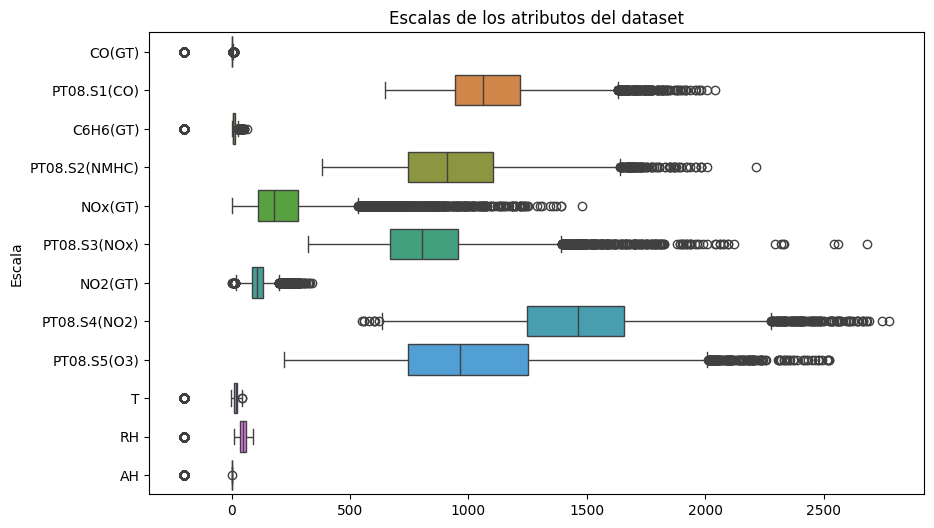

In [21]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, orient = 'h')
plt.title('Escalas de los atributos del dataset')
plt.ylabel('Escala')
plt.show()

En la imagen superior podemos ver la escala de los datos, y, aparte de tener una gran cantidad de outliers como dec√≠amos previamente, la escala es muy dispar, por lo que tenemos que aplicar normalizaci√≥n. En nuestro caso vamos a eliminar los outliers extremos usando el m√©todo del rango intercuart√≠lico (IQR), y tras eso aplicaremos normalizaci√≥n, en nuestro caso hemos elegido RobustScaler, ya que usa la mediana y el rango intercuartil en lugar de la media y desviaci√≥n est√°ndar, lo que lo hace m√°s robusto.

<ipython-input-22-d438471d8c1e>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[columnas_numericas] = scaler.fit_transform(df[columnas_numericas])


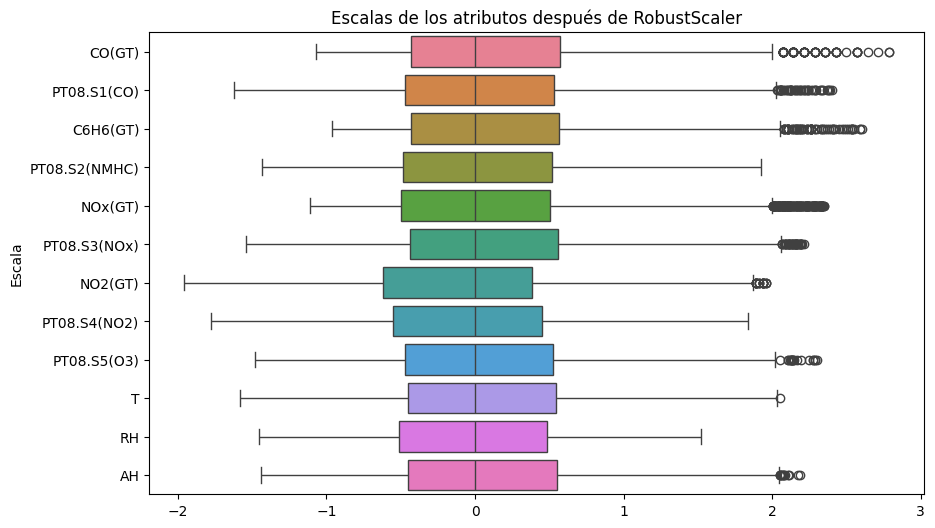

In [22]:
# Seleccionar solo las columnas num√©ricas
columnas_numericas = df.select_dtypes(include=["float64"]).columns

Q1 = df[columnas_numericas].quantile(0.25)
Q3 = df[columnas_numericas].quantile(0.75)
IQR = Q3 - Q1

# Filtrar valores dentro de 1.5*IQR
df = df[~((df[columnas_numericas] < (Q1 - 1.5 * IQR)) | (df[columnas_numericas] > (Q3 + 1.5 * IQR))).any(axis=1)]

# Aplicar RobustScaler
scaler = RobustScaler()
df[columnas_numericas] = scaler.fit_transform(df[columnas_numericas])

# Verificar con boxplot despu√©s de escalar

plt.figure(figsize=(10,6))
sns.boxplot(data=df[columnas_numericas], orient='h')
plt.title('Escalas de los atributos despu√©s de RobustScaler')
plt.ylabel('Escala')
plt.show()


El siguiente paso es estudiar correlaci√≥n entre las variables, para ello vamos a hacer un plot de una matriz de correlaci√≥n. Vamos a seguir el siguiente criterio:

- r > 0.7 o r < -0.7 ‚Üí Fuerte correlaci√≥n
- 0.5 < |r| < 0.7 ‚Üí Correlaci√≥n moderada
- |r| < 0.5 ‚Üí D√©bil o sin correlaci√≥n

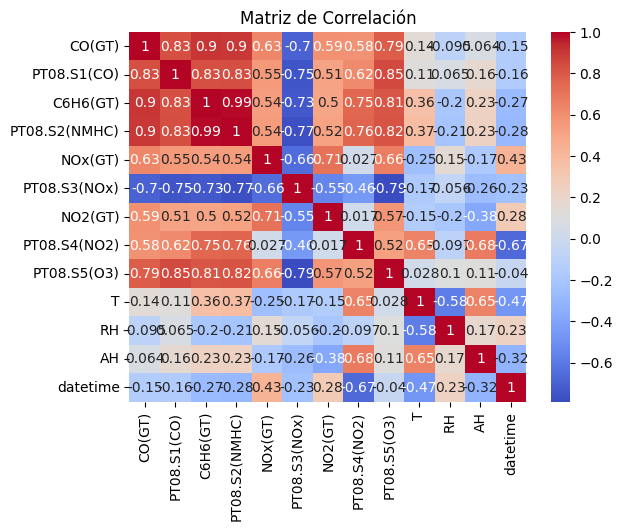

In [23]:
sns.heatmap(df.corr(),annot=True,cmap = 'coolwarm')
plt.title('Matriz de Correlaci√≥n')
plt.show()

En la imagen, se observa lo siguiente:

- C6H6(GT) y PT08.S2(NMHC) tienen una correlaci√≥n de ~0.99
- PT08.S5(O3) y PT08.S1(CO) tienen alta correlaci√≥n (~0.85 - 0.9)
- CO(GT) y C6H6(GT) est√°n altamente correlacionadas (~0.9)

Evidentemente hay m√°s variables altamente correlacionadas, pero esas son las m√°s notables.

Lo que vamos a hacer es eliminar C6H6 y CO (GT) por estar altamente correlacionadas entre s√≠ y con la variable PT08.S2(NMHC) para evitar problemas de multicolinealidad.

In [24]:
# Eliminar variables redundantes
df = df.drop(columns=["C6H6(GT)", "CO(GT)"])

print(df.columns)

Index(['PT08.S1(CO)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)',
       'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH', 'datetime'],
      dtype='object')


Por √∫ltimo, lo que vamos a hacer es introducir nuevas caracter√≠sticas que puedan resultar interesantes. Los datos tienen un componente temporal importante, ya que todos los datos est√°n modelados seg√∫n un instante de tiempo que ahora tenemos definido con DateTime. Para poder aprovechar ese car√°cter secuencial de los datos lo que vamos a hacer es intruducir las siguientes variables: Hora del d√≠a, d√≠a de la semana, d√≠a y semana del a√±o y mes. De esta manera eliminamos DateTime (ya que al no ser numerica no podemos usarla para entrenamiento) pero mantenemos informaci√≥n relativa al tiempo, pudiendo estudiar la estacionalidad.

In [25]:
# Extraer caracter√≠sticas temporales del datetime
df["hour"] = df["datetime"].dt.hour  # Hora del d√≠a (0-23)
df["day_of_week"] = df["datetime"].dt.dayofweek  # D√≠a de la semana (0=Monday, ..., 6=Sunday)
df["month"] = df["datetime"].dt.month  # Mes (1-12)
df["day_of_year"] = df["datetime"].dt.dayofyear  # D√≠a del a√±o (1-365)
df["week_of_year"] = df["datetime"].dt.isocalendar().week  # Semana del a√±o

# Ahora podemos eliminar la columna datetime
df = df.drop(columns=["datetime"])

In [26]:
df.head()

PT08.S1(CO)  PT08.S2(NMHC)   NOx(GT)  PT08.S3(NOx)   NO2(GT)  PT08.S4(NO2)  \
0     1.289916       0.496815 -0.079470      0.921002  0.085106      0.551876   
1     1.004202       0.207006 -0.496689      1.375723 -0.361702      0.258278   
2     1.466387       0.156051 -0.311258      1.244701  0.106383      0.249448   
3     1.357143       0.184713 -0.039735      1.059730  0.276596      0.313466   
4     0.920168      -0.171975 -0.311258      1.495183  0.148936      0.105960   

   PT08.S5(O3)         T        RH        AH  hour  day_of_week  month  \
0     0.721348 -0.337349  0.029963 -0.398218    18            2      3   
1     0.056180 -0.361446 -0.014981 -0.456951    19            2      3   
2     0.285393 -0.473896  0.220974 -0.412037    20            2      3   
3     0.575281 -0.546185  0.445693 -0.345668    21            2      3   
4     0.366292 -0.530120  0.430712 -0.341849    22            2      3   

   day_of_year  week_of_year  
0           70            11  
1           70            11  
2           70            11  
3           70            11  
4           70            11

Llegados a este punto ya tenemos el dataset listo para empezar a experimentar con los entrenamientos de los modelos.

# **Entrenamiento de modelos de ML**

Para proceder con el entrenamiento hay que elegir una variable target, en nuestro caso hemos optado por el sensor PT08.S1(CO), ya que puede ser un buen indicador de la calidad del aire.

In [27]:
# Separar variables predictoras (X) y variable objetivo (Y)
y = df["PT08.S1(CO)"]
X = df.drop(columns=["PT08.S1(CO)"])  # Eliminamos la variable objetivo y datetime

X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

# Divisi√≥n del dataset en 80% entrenamiento y 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

print(f"Train Shape: {X_train.shape}, Test Shape: {X_test.shape}")

Train Shape: (5007, 14), Test Shape: (1252, 14)


## Random Forest Regressor

Entrenamos un modelo Random Forest para regresi√≥n mediante el ajuste de hiperpar√°metros con validaci√≥n cruzada de 3 pliegues. Como estamos en regresi√≥n, la m√©trica que nos indicar√° el mejor modelo es el coeficiente de determinaci√≥n $R^2$, que indica qu√© tan bien un modelo de regresi√≥n explica la variabilidad de la variable objetivo en funci√≥n de las variables independientes (features).

In [28]:
# Definir la cuadr√≠cula de hiperpar√°metros
param_grid = {
    "n_estimators": [50, 75, 100],
    "max_depth": [5, 10, 15],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

# Crear el modelo base
rf_model = RandomForestRegressor(random_state=random_state)

# Configurar Grid Search
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                           cv=3, scoring="r2", n_jobs=-1, verbose=2)

# Ajustar el modelo con Grid Search
grid_search.fit(X_train, y_train)

# Imprimir los mejores hiperpar√°metros encontrados
print("Mejores hiperpar√°metros encontrados:")
print(grid_search.best_params_)

# Obtener el mejor modelo
best_rf = grid_search.best_estimator_

# Hacer predicciones con el mejor modelo
y_pred_best = best_rf.predict(X_test)

# Evaluar m√©tricas
print("\nRandom Forest Optimizado")
print(f"R¬≤ Score: {r2_score(y_test, y_pred_best):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_best):.4f}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, y_pred_best):.4f}")

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Mejores hiperpar√°metros encontrados:
{'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Random Forest Optimizado
R¬≤ Score: 0.9556
MAE: 0.1130
MAPE: 955489110942.2528


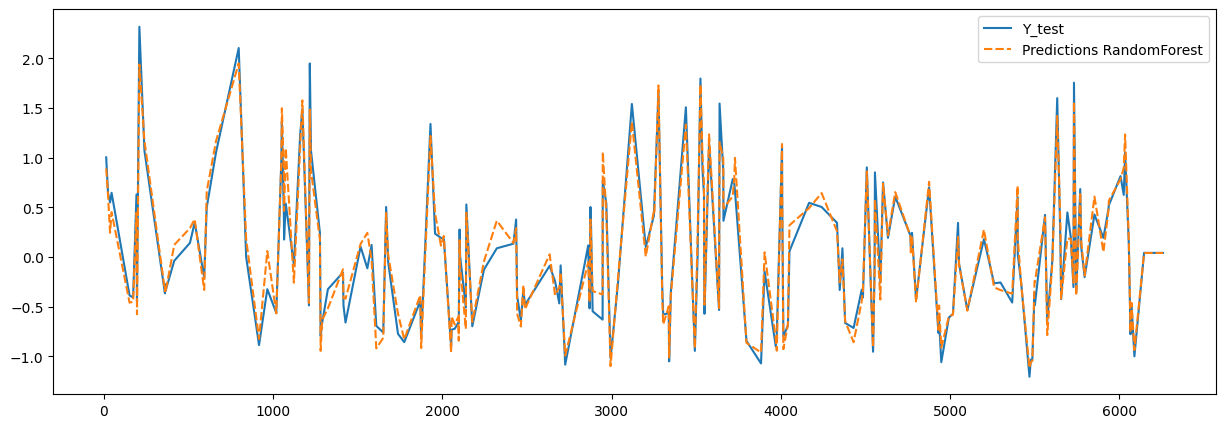

In [29]:
aux = pd.DataFrame()

aux['Y_test'] = y_test
aux['Predictions RandomForest'] = y_pred_best

plt.figure(figsize=(15,5))
sns.lineplot(data=aux.iloc[:200,:])
plt.show()

Podemos observar que el modelo RF se adapta bastante bien en sus predicciones a la variable objetivo, aunque s√≠ que es cierto que le cuesta un poco predecir los picos m√°s abruptos. De todos modos el R2 score es de 0.95 y el MAE de 0.11, lo que indica un rendimiento excelente.

In [30]:
# Guardar el modelo entrenado
joblib.dump(best_rf, "/content/MLEX-Practicas/training_models/random_forest_model.pkl")

['/content/MLEX-Practicas/training_models/random_forest_model.pkl']

# M√©todos de ML explicativos

## LIME

Comenzamos utilizando el m√©todo LIME (Local Interpretable Model-Agnostic Explanations) para dar una exlicaci√≥n local (es decir, de una √∫nica instancia) del funcionamiento de los modelos de caja negra que hemos entrenado en el apartado anterior.

### Crear el explicador LIME

In [31]:
# LIME explainer para datos tabulares
explainer = LimeTabularExplainer(X.values, # Para generar el vecindario artificial
                                 feature_names=X.columns,
                                 class_names=["PT08.S1(CO)"], # La variable objetivo (target)
                                 mode = 'regression', # Estamos en modo regresi√≥n
                                 random_state=random_state)

## Explicaci√≥n local de una instancia

Seleccionamos una instancia aleatoria del dataset y daremos una epxlicaci√≥n de la salida obtenida por los modelos de caja negra para esa instancia a trav√©s de un modelo sub-rogado, que ser√° en este caso un modelo lineal Ridge (por defecto en LIME).

Definimos una funci√≥n gen√©rica, `local_explanation_lime`, para generar la explicaci√≥n local. Esta funci√≥n que recibe como argumentos:
- Indice en el dataset de la instancia a explicar.
- Modelo de caja negra.

In [32]:
def local_explanation_lime(index_instance: int, blackBoxModel, show = False):
    # Validar que el √≠ndice est√© en el rango correcto
    assert 0 <= index_instance < X.shape[0], "Index out of bounds"

    # Generar la explicaci√≥n para la instancia dada
    exp = explainer.explain_instance(
        X.loc[index_instance].values,  # Instancia a explicar
        blackBoxModel.predict,
        num_features=X.shape[1]  # N√∫mero de caracter√≠sticas a incluir en la explicaci√≥n
    )

    # Mostrar la explicaci√≥n en Jupyter Notebook
    if show:
        exp.show_in_notebook(show_all=False)

    # Obtener e imprimir los coeficientes de la explicaci√≥n local
    explainer_list = exp.as_map()[1]
    explainer_list = sorted(explainer_list, key=lambda x: x[0])
    feature_importance = [x[1] for x in explainer_list]

    return feature_importance  # Opcionalmente, devolver la lista

In [33]:
# Cargar el modelo guardado en otro momento
model_rf = joblib.load("/content/MLEX-Practicas/training_models/random_forest_model.pkl")

In [34]:
# Fijar semilla y seleccionar un √≠ndice de instancia aleatorio
indice_aleatorio = X.sample(n=1, random_state=random_state).index[0]

In [35]:
# Salida esperada:
y.loc[indice_aleatorio]

np.float64(-0.8571428571428571)

In [36]:
# Generar la explicaci√≥n para esa instancia
lime_weights = pd.DataFrame(local_explanation_lime(indice_aleatorio, model_rf, show = True)).T

En la salida anterior, la barra central con dos campos: negative y positive; es la lista de caracter√≠sticas ordenadas por su influencia en la variable objetivo. Se utiliza el color azul para variables que disminuyen el valor de predicci√≥n (negative) y el color naranja para las features con un impacto positivo en el target (positive). La longitud de las barras de colores indica el impacto de la feature en la predicci√≥n y vemos como ese tama√±o va disminuyendo conforme bajamos en la lista. Por tanto, conclu√≠mos que la variable que m√°s impacto tiene en la predicci√≥n es `PT08.S5(O3)`.

La tabla de abajo muestra el valor de las variables o features (marcadas en distinto color en base a su influencia en el target) en la instancia que se quiere explicar.

Podemos observar los coeficientes reales asignados a cada feature para esta instancia, o lo que es lo mismo, los valores de los coeficientes $\beta_i$ en el modelo de regresi√≥n lineal Ridge:

In [37]:
lime_weights.columns = X.columns
lime_weights

PT08.S2(NMHC)   NOx(GT)  PT08.S3(NOx)   NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0      -0.044899 -0.016048     -0.221803 -0.017342      0.052129    -0.302504   

          T        RH      AH      hour  day_of_week    month  day_of_year  \
0 -0.004061 -0.004952  0.0045 -0.025858    -0.010834  0.03312    -0.159747   

   week_of_year  
0     -0.094951

## Interpretaci√≥n de los resultados de LIME

Este an√°lisis explica el impacto de cada variable en la predicci√≥n del sensor **PT08.S1 (CO)**. Los coeficientes obtenidos muestran qu√© caracter√≠sticas influyen m√°s en la predicci√≥n del modelo.

---

## üîπ Factores que M√ÅS REDUCEN la Predicci√≥n (`Impacto negativo`)
Estas variables tienen un **efecto negativo en la predicci√≥n**, es decir, a **mayores valores**, la predicci√≥n del sensor de CO tiende a disminuir.

| **Variable**          | **Peso LIME** | **Interpretaci√≥n** |
|----------------------|--------------|----------------|
| **PT08.S5 (O3)**    | **-0.3025**   | Un mayor nivel de **ozono (O‚ÇÉ)** reduce la predicci√≥n del mon√≥xido de carbono, lo que puede indicar una relaci√≥n inversa entre estos contaminantes. |
| **PT08.S3 (NOx)**   | **-0.2218**   | Un aumento en la concentraci√≥n de **√≥xidos de nitr√≥geno (NOx)** en este sensor reduce la predicci√≥n del CO, lo que puede estar asociado con diferentes fuentes de emisi√≥n. |
| **day_of_year**      | **-0.1597**   | La √©poca del a√±o influye en la concentraci√≥n de CO. Durante ciertos periodos del a√±o, los niveles de CO pueden disminuir debido a cambios estacionales. |


---

## üîπ Factores que M√ÅS AUMENTAN la Predicci√≥n (`Impacto positivo`)
Estas variables tienen un **efecto positivo en la predicci√≥n**, es decir, a **mayores valores**, la predicci√≥n del sensor de CO tiende a aumentar.

| **Variable**       | **Peso LIME** | **Interpretaci√≥n** |
|-------------------|--------------|----------------|
| **PT08.S4 (NO2)** | **+0.0552**  | Un incremento en la respuesta del sensor de **di√≥xido de nitr√≥geno (NO‚ÇÇ)** tiene un efecto positivo en la predicci√≥n del CO. |
| **AH (Humedad absoluta)** | **+0.0045** | Un leve aumento en la humedad absoluta podr√≠a estar asociado con una mayor presencia de mon√≥xido de carbono. |
| **month**         | **+0.0331**  | La variaci√≥n mensual afecta la concentraci√≥n de CO, posiblemente debido a patrones estacionales o meteorol√≥gicos. |


---

**Interpretaci√≥n general:**
- Un **aumento en los niveles de ozono y √≥xidos de nitr√≥geno** est√° asociado con **una menor concentraci√≥n de CO detectada por el sensor**.
- **Factores temporales** (d√≠a y semana del a√±o) tambi√©n afectan la predicci√≥n, posiblemente debido a variaciones estacionales y patrones de tr√°fico.
- La humedad absoluta y la presencia de NO‚ÇÇ tienen un **leve efecto positivo** en la predicci√≥n de CO.

---

**Explicaci√≥n informal a un cliente**:

Cuando hay m√°s ozono (O‚ÇÉ) y √≥xidos de nitr√≥geno (NOx) en el aire, parece que el sensor detecta menos CO. Quiz√°s porque estos contaminantes provienen de fuentes diferentes o porque hay reacciones qu√≠micas en la atm√≥sfera que los hacen disminuir juntos. Tambi√©n influye en qu√© √©poca del a√±o estamos. Si estamos en ciertas semanas del a√±o o meses, parece que el CO baja. Esto tiene sentido, porque en invierno, por ejemplo, la gente usa m√°s calefacci√≥n, y en verano los gases se dispersan m√°s.

## Explicaci√≥n pseudo-global con LIME

Usamos el modelo local LIME para intentar dar una explicaci√≥n global de las predicciones que est√° dando el modelo de caja negra, que en este caso es el Random Forest.

Para ello, aplicaremos LIME a 500 ejemplos diferentes del dataset y guardaremos los pesos de las explicaciones individuales. Una vez hecho eso, podemos usar el promedio de los pesos obtenidos para cada feature con el objetivo de tener una idea de c√≥mo est√°n contribuyendo de manera global.

In [38]:
weights = []
for i in range(500):
    weights.append(local_explanation_lime(i, model_rf, show = False))

In [39]:
#Create DataFrame to manipulate the explanations.
lime_weights = pd.DataFrame(weights)
lime_weights.columns = X.columns
lime_weights.head()

PT08.S2(NMHC)   NOx(GT)  PT08.S3(NOx)   NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0       0.053014 -0.013258     -0.205139 -0.028187      0.252227     0.636180   
1       0.079995 -0.032235     -0.168071 -0.000616      0.061818     0.000537   
2       0.068488  0.013111     -0.220244  0.030981      0.082821    -0.035832   
3       0.071351 -0.015842     -0.207722 -0.007495      0.057146     0.635950   
4      -0.052396 -0.020202     -0.174498  0.001273      0.056206    -0.031723   

          T        RH        AH      hour  day_of_week     month  day_of_year  \
0  0.009565  0.005316 -0.021014  0.007640    -0.021520  0.020103     0.232155   
1 -0.013102 -0.016484 -0.048662 -0.023065    -0.011051  0.023999     0.224273   
2 -0.011818 -0.009904 -0.012880  0.015981    -0.012263  0.005356     0.236624   
3  0.005219 -0.010592 -0.019909  0.024636    -0.032102  0.021163     0.236598   
4 -0.008531  0.024776 -0.025777  0.013031     0.019429 -0.000869     0.241798   

   week_of_year  
0      0.118586  
1      0.128911  
2      0.111254  
3      0.112772  
4      0.124812

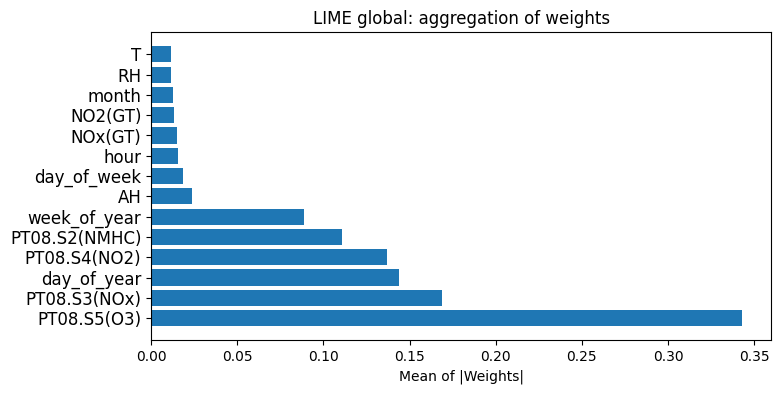

In [40]:
# compute absolute mean
abs_mean = lime_weights.abs().mean()

#dataframe with 2 columns: feature name and absolute mean
abs_mean = pd.DataFrame(data = {'feature':abs_mean.index, 'abs_mean':abs_mean})
abs_mean = abs_mean.sort_values(by='abs_mean', ascending=False)
abs_mean.head()

# SHOW IN A BAR PLOT
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,4))
y_ticks = range(len(abs_mean))
y_labels = abs_mean.feature

plt.barh(y = y_ticks, width = abs_mean.abs_mean)
plt.yticks(ticks = y_ticks, labels = y_labels, size = 12)
plt.title('LIME global: aggregation of weights')
plt.ylabel('')
plt.xlabel('Mean of |Weights|')
plt.show()

### Interpretaci√≥n del gr√°fico: Importancia global de las variables seg√∫n LIME

El gr√°fico anterior muestra el **promedio del valor absoluto de los pesos** asignados por **LIME** a cada variable a lo largo de m√∫ltiples explicaciones locales. Es decir, refleja cu√°nto ha contribuido cada caracter√≠stica, en promedio, a las predicciones del modelo.

---

#### Variables m√°s influyentes:
- **PT08.S5(O3)** es la variable **m√°s influyente**, con un peso medio absoluto cercano a **0.34**. Esto indica que tiene un impacto muy significativo en la mayor√≠a de predicciones.
- Le siguen **PT08.S3(NOx)** (0.18) y **PT08.S4(NO2)** (0.13), tambi√©n con contribuciones relevantes. Estas variables est√°n asociadas a sensores de contaminantes, lo cual es coherente si la variable objetivo est√° relacionada con la calidad del aire.

---

#### Variables moderadamente influyentes:
- **day_of_year**, **PT08.S2(NMHC)** y **week_of_year** muestran pesos medios entre **0.10 y 0.12**, indicando que el modelo tambi√©n se ve afectado por **factores temporales o estacionales**.

#### Variables poco influyentes:
- Variables como **AH**, **hour**, **NOx(GT)**, **month**, **RH** y especialmente **T (temperatura)** tienen pesos muy bajos (< 0.05), por lo que su influencia promedio en las predicciones es **limitada o marginal**.

---

### Conclusi√≥n
El modelo se basa principalmente en las lecturas de los sensores qu√≠micos, sobre todo en los niveles de **ozono (O‚ÇÉ)** y √≥xidos de nitr√≥geno (**NOx**, **NO‚ÇÇ**), lo que tiene sentido si el objetivo es predecir o analizar la contaminaci√≥n del aire.

Las variables temporales tienen una influencia secundaria, y las condiciones meteorol√≥gicas como la temperatura y la humedad tienen **poca relevancia global** seg√∫n LIME.


## SHAP

In [41]:
explainer = shap.Explainer(best_rf)

In [42]:
shap_values = explainer(X_test)

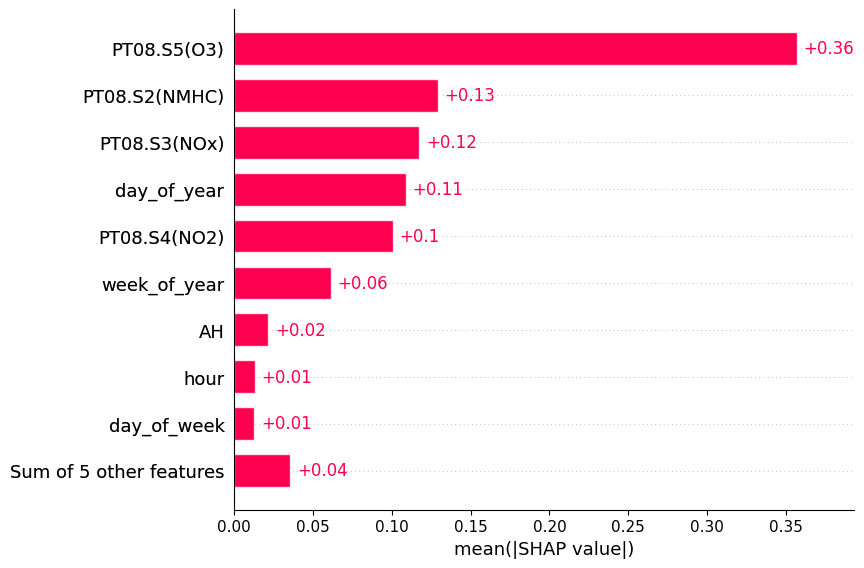

In [43]:
shap.plots.bar(shap_values)

### Interpretaci√≥n del gr√°fico de barras global de SHAP

Este gr√°fico representa la **importancia media** de cada variable en las predicciones del modelo, medida mediante el valor absoluto medio de los valores SHAP. Esto refleja cu√°nto contribuye cada atributo, en promedio, a las decisiones del modelo.

- La variable **PT08.S5(O3)** es la m√°s influyente, con una contribuci√≥n media de `+0.36`, lo que indica un fuerte impacto en la predicci√≥n general.
- A continuaci√≥n, destacan **PT08.S2(NMHC)** (`+0.13`) y **PT08.S3(NOx)** (`+0.12`), ambas relacionadas con la calidad del aire.
- Tambi√©n tienen un papel importante variables temporales como **day_of_year** (`+0.11`) y **week_of_year** (`+0.06`).
- Variables como **AH** (humedad absoluta), **hour** o **day_of_week** muestran una contribuci√≥n media menor, aunque no deben ser descartadas.

> El hecho de que algunas variables tengan una importancia media baja **no implica que no sean relevantes**. El gr√°fico resume la contribuci√≥n **media absoluta** a lo largo de todas las instancias, pero una variable puede tener un impacto muy significativo en ciertos casos (positivo o negativo) y aun as√≠ aparecer con baja importancia media. Por tanto, este gr√°fico ofrece una visi√≥n global, pero no refleja el comportamiento individual en cada predicci√≥n.

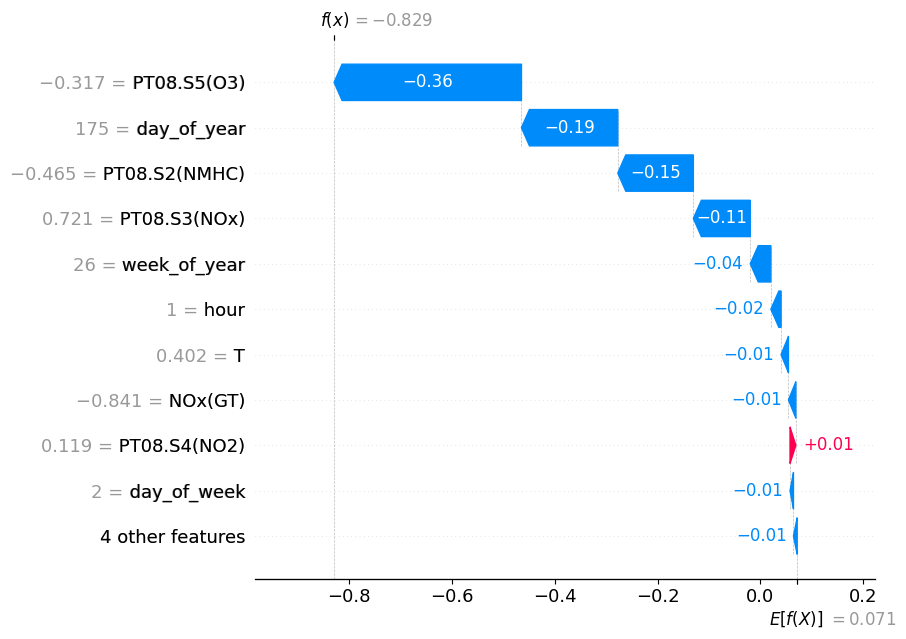

In [44]:
shap.plots.waterfall(shap_values[0], max_display=11)

### Interpretaci√≥n de la gr√°fica Waterfall de SHAP

La gr√°fica *waterfall* de SHAP muestra c√≥mo cada caracter√≠stica contribuye a la predicci√≥n de un registro espec√≠fico con respecto a un valor base (la media de las predicciones, en este caso `E[f(X)] = 0.071`).

1. **Eje horizontal:** representa la escala de la predicci√≥n.  
2. **Predicci√≥n final:** se alcanza el valor `f(x) = -0.829` al aplicar las contribuciones (valores SHAP) de cada caracter√≠stica a la media.  
3. **Barras negativas (azules) y positivas (rojas):** indican si cada caracter√≠stica reduce (desplazamiento a la izquierda) o aumenta (desplazamiento a la derecha) el valor final.  
4. **Etiquetas de valor:** el texto a la izquierda (por ejemplo, `-0.317 = PT08.S5(O3)`) corresponde al valor real de la caracter√≠stica; el valor sobre la barra (por ejemplo, `-0.36`) indica la magnitud de su efecto sobre la predicci√≥n.  

En este ejemplo, la variable `PT08.S5(O3)` se asocia con la mayor contribuci√≥n negativa (`-0.36`), seguida por `PT08.S2(NMHC)`, `day_of_year`, `PT08.S3(NOx)`, entre otras, que contin√∫an disminuyendo el valor estimado con respecto a la media. El resultado de la suma de todas las aportaciones es la predicci√≥n final `f(x) = -0.829`.

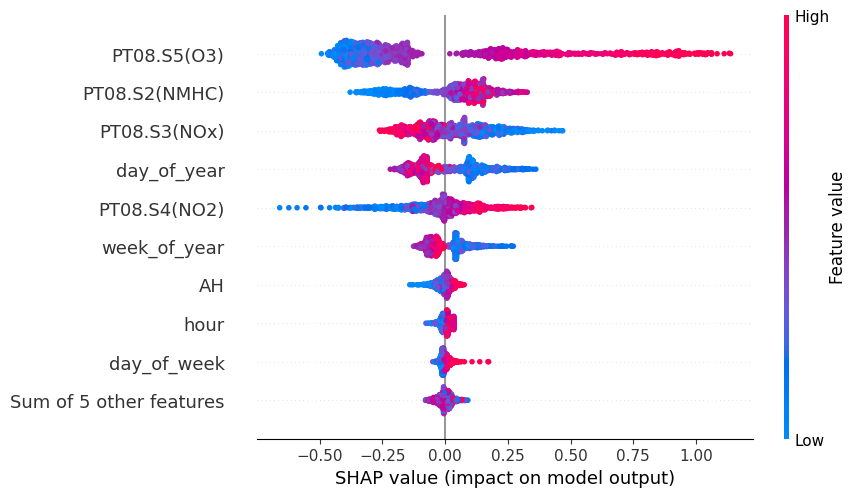

In [45]:
shap.plots.beeswarm(shap_values)

### Interpretaci√≥n de la gr√°fica Beeswarm de SHAP

La gr√°fica *beeswarm* ordena las caracter√≠sticas por su **importancia general** (amplitud de valores SHAP) y muestra la **distribuci√≥n** de sus efectos en cada instancia del conjunto de datos.

- **Eje X (SHAP value):** indica el impacto de la caracter√≠stica sobre la predicci√≥n. Valores positivos desplazan la salida del modelo hacia arriba; valores negativos la desplazan hacia abajo.
- **Colores (alto vs. bajo):** cada punto representa una muestra. El color se√±ala el valor real de esa caracter√≠stica (rojo para valores m√°s altos, azul para valores m√°s bajos).
- **Amplitud y dispersi√≥n:** cuanto mayor es la extensi√≥n horizontal de los puntos para una caracter√≠stica, mayor es la variabilidad de su impacto en el modelo. Una caracter√≠stica con puntos muy dispersos a izquierda y derecha posee un efecto m√°s diverso (y, por tanto, una mayor importancia media).

En el ejemplo, se aprecia que `PT08.S5(O3)` y `PT08.S2(NMHC)` presentan el rango de valores SHAP m√°s amplio, lo cual indica una contribuci√≥n significativa en la predicci√≥n de `PT08.S1(CO)`. El color de los puntos (rojo/azul) revela c√≥mo valores altos o bajos de cada sensor/variable tienden a empujar la salida del modelo en un sentido u otro.


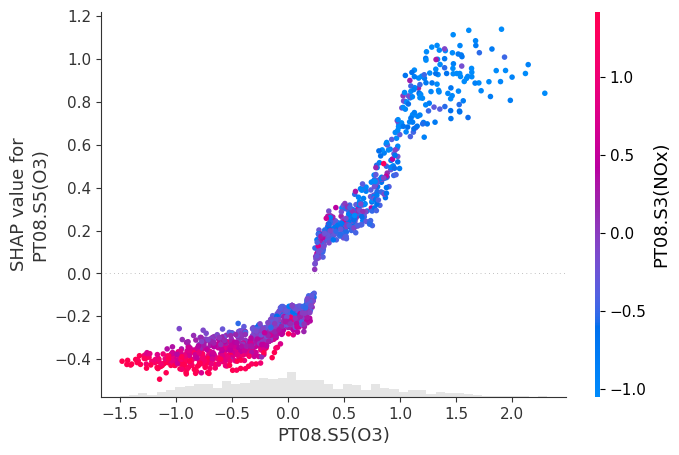

In [46]:
shap.plots.scatter(shap_values[:,"PT08.S5(O3)"], color=shap_values)

### Interpretaci√≥n de la gr√°fica Scatter de SHAP

Este diagrama *scatter* relaciona los valores de la variable `PT08.S5(O3)` (eje X) con su correspondiente valor SHAP (eje Y), mostrando c√≥mo cambios en la caracter√≠stica influyen en la predicci√≥n. El color de los puntos (seg√∫n la barra a la derecha) representa el valor de otra variable ‚Äîen este caso, `PT08.S3(NOx)`‚Äî lo que permite observar posibles interacciones.

1. **Eje X (Valor de `PT08.S5(O3)`):** muestra la medida real del sensor `PT08.S5(O3)` en cada instancia.
2. **Eje Y (Valor SHAP de `PT08.S5(O3)`):** indica en qu√© medida esa variable desplaza la salida del modelo por encima (valores positivos) o por debajo (valores negativos) de la predicci√≥n base.
3. **Color (Valor de `PT08.S3(NOx)`):** la gradaci√≥n de colores (azul/rojo) a√±ade una tercera dimensi√≥n, revelando posibles sinergias o efectos combinados de `PT08.S5(O3)` y `PT08.S3(NOx)` sobre la predicci√≥n.
4. **Curva de tendencia:** se aprecia c√≥mo, a medida que aumenta el valor de `PT08.S5(O3)`, el valor SHAP tiende a pasar de negativo a positivo (o viceversa). Esto indica el punto aproximado en que esta caracter√≠stica empieza a incrementar la salida del modelo en lugar de disminuirla.

En conjunto, la gr√°fica permite identificar patrones no lineales y la interacci√≥n entre `PT08.S5(O3)` y `PT08.S3(NOx)`, brindando una visi√≥n m√°s profunda de c√≥mo las lecturas de estos dos sensores influyen conjuntamente en la estimaci√≥n de la variable objetivo.
